In [1]:
# Import all the necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

C:\Users\felipe.figueiredo\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\felipe.figueiredo\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\felipe.figueiredo\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# Reset pseudo random number generator so that the results are reproducible.
np.random.seed(42)

## Generating the target function and its noisy version.

In [3]:
# Sets the number of examples.
N = 20

# Attribute.
x = np.sort(3*np.random.rand(N, 1), axis=0)

# Target function.
y = 1 + 0.5*x

# Noisy function.
y_noisy = y + np.random.randn(N, 1)/1.5

Ntest = 100
x_test = np.linspace(0, 3, Ntest).reshape(Ntest, 1)
y_test = 1 + 0.5*x_test + np.random.randn(Ntest, 1)/1.5

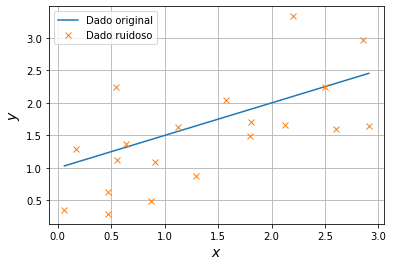

In [4]:
# Plot original data versus noisy version.
plt.plot(x, y, label='Dado original')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
#plt.savefig("target_function.png", dpi=600)
#Show the plot.
plt.show()

## Define the polinomial order

In [5]:
# Polynomial order.
model_order = 10

## Define the regularization factor

In [6]:
# Regularization factor.
lambdas = [0, 10**-5, 1]

## Manually Implemented Closed-form solution

É importante escalonar os dados (por exemplo, usando a classe StandardScaler) antes de realizar a regressão de Ridge, pois ela é bastante sensível à escala dos atributos.

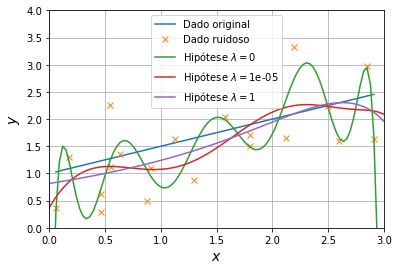

In [7]:
# Concatenate both column vectors.
X = np.ones((N,1))
for i in range(1, model_order+1):
    X = np.c_[X, np.power(x, i)]

# Instantiate standard scaler. 
scaler = StandardScaler()

# Train and standardize samples.
X = np.c_[np.ones((N,1)), scaler.fit_transform(X[:,1:])]

# Concatenate both column vectors.
X_test = np.ones((Ntest,1))
for i in range(1, model_order+1):
    X_test = np.c_[X_test, np.power(x_test, i)]

# Standardize validation samples.
X_test = np.c_[np.ones((Ntest,1)), scaler.transform(X_test[:,1:])]

I = np.eye(model_order+1)
I[0,0] = 0

# Plot original data versus noisy version.
plt.plot(x, y, label='Dado original')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
for i in range(0,len(lambdas)):
    # Closed-form solution.
    a_opt = np.linalg.pinv(np.transpose(X).dot(X) + I.dot(lambdas[i])).dot(np.transpose(X).dot(y_noisy))
    # Predict.
    y_test = X_test.dot(a_opt)
    # Plot prediction.
    plt.plot(x_test, y_test, label='Hipótese $\lambda=$'+str(lambdas[i]))
    
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
plt.axis([0, 3, 0, 4])
#Show the plot.
plt.show()

## Closed-form solution with SciKit-Learn 

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

O solver=‘cholesky’ usa a função scipy.linalg.solve padrão para obter uma solução de forma fechada.

Essa solução é equivalente à implementada manualmente.

Existem outros solvers.

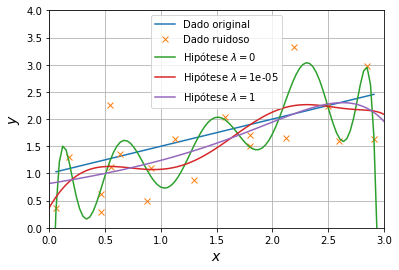

In [8]:
include_bias = True

# Plot original data versus noisy version.
plt.plot(x, y, label='Dado original')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
for i in range(0,len(lambdas)):

    # Instantiate a polynomial with the given degree.
    poly_features = PolynomialFeatures(degree=model_order, include_bias=include_bias)
    # Instantiate a scaler that will standardize the features.
    std_scaler = StandardScaler()
    # Instantiate a Ridge regressor.
    reg = Ridge(alpha=lambdas[i], solver="cholesky")
    # Create a pipeline of actions.
    model = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("reg", reg),
    ])
    # Train model.
    model.fit(x, y_noisy)
    # Predict.
    y_test_regul = model.predict(x_test)
    # Plot prediction.
    plt.plot(x_test, y_test_regul, label='Hipótese $\lambda=$'+str(lambdas[i]))
    
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
plt.axis([0, 3, 0, 4])
# Save figure
plt.savefig("ridge_regression.png", dpi=600)
#Show the plot.
plt.show()

## Weight variation versus lambda

In [9]:
include_bias = True

M = 1000
lambdas = np.linspace(1e-5,1, M)

a_hist = np.zeros((model_order, M))
norm_hist = np.zeros((1, M))
error_test = []

for i in range(0,len(lambdas)):
    # Instantiate a polynomial with the given degree.
    poly_features = PolynomialFeatures(degree=model_order, include_bias=include_bias)
    # Instantiate a scaler that will standardize the features.
    std_scaler = StandardScaler()
    # Instantiate a Ridge regressor.
    reg = Ridge(alpha=lambdas[i], solver="cholesky")
    # Create a pipeline of actions.
    model = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("reg", reg),
    ])
    # Train model.
    model.fit(x, y_noisy)
    a = model.named_steps['reg'].coef_[0,1:model_order+1]
    a_hist[:,i] = a
    norm_hist[:,i] = np.linalg.norm(a)
    # Predict.
    y_test_regul = model.predict(x_test)
    error_test.append((mean_squared_error(y_test, y_test_regul)))

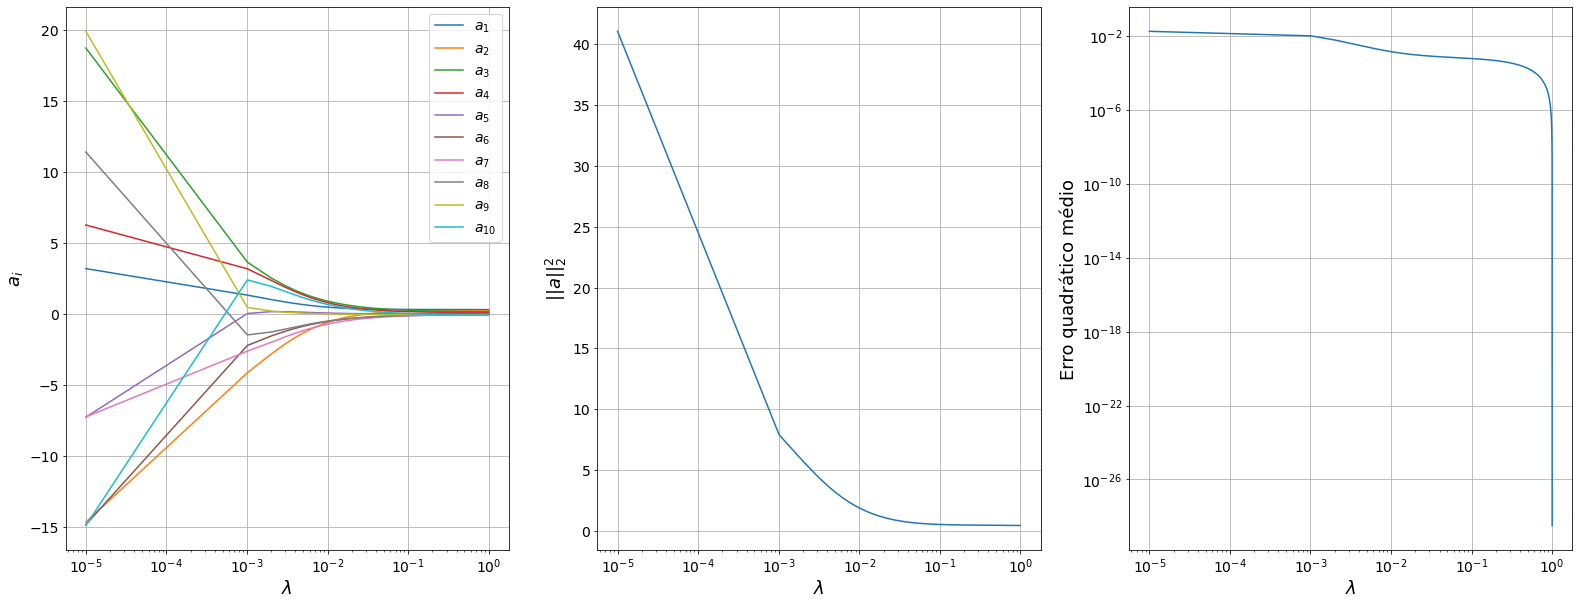

In [10]:
# Create figure.
fig = plt.figure(figsize=(27,10))

# Plot weight.
ax = plt.subplot(1, 3, 1)
for i in range(0,model_order): 
    plt.plot(lambdas, a_hist[i,:], label='$a_{'+str(i+1)+'}$')
ax.tick_params(axis = 'both', which = 'both', labelsize = 14)
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=18)
plt.ylabel('$a_i$', fontsize=18)
plt.legend(loc='upper right', fontsize=14)
plt.grid()

# Plot norm.
ax = plt.subplot(1, 3, 2)
plt.plot(lambdas, norm_hist[0,:])
ax.tick_params(axis = 'both', which = 'both', labelsize = 14)
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=18)
plt.ylabel('$||a||_2^2$', fontsize=18)
plt.grid()

# Plot error.
ax = plt.subplot(1, 3, 3)
plt.plot(lambdas, error_test)
ax.tick_params(axis = 'both', which = 'both', labelsize = 14)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$', fontsize=18)
plt.ylabel('Erro quadrático médio', fontsize=18)
plt.grid()

#Show the plot.
plt.show()

ax.tick_params(reset=True)

In [24]:
print('                     a1        a2         a3       a4         a5')
for i in range(0, M):
    print('lambda %1.2e: %1.2e, %1.2e, %1.2e, %1.2e, %1.2e' % (lambdas[i],a_hist[0,i],a_hist[1,i],a_hist[2,i],a_hist[3,i],a_hist[4,i]))

                     a1        a2         a3       a4         a5
lambda 1.00e-05: 3.18e+00, -1.47e+01, 1.87e+01, 6.25e+00, -7.28e+00
lambda 1.01e-03: 1.31e+00, -4.15e+00, 3.64e+00, 3.17e+00, 1.89e-02
lambda 2.01e-03: 1.00e+00, -2.82e+00, 2.51e+00, 2.34e+00, 1.51e-01
lambda 3.01e-03: 8.28e-01, -2.10e+00, 1.97e+00, 1.86e+00, 1.48e-01
lambda 4.01e-03: 7.19e-01, -1.65e+00, 1.64e+00, 1.55e+00, 1.29e-01
lambda 5.01e-03: 6.43e-01, -1.34e+00, 1.42e+00, 1.32e+00, 1.10e-01
lambda 6.02e-03: 5.88e-01, -1.12e+00, 1.25e+00, 1.16e+00, 9.41e-02
lambda 7.02e-03: 5.46e-01, -9.44e-01, 1.13e+00, 1.03e+00, 8.08e-02
lambda 8.02e-03: 5.13e-01, -8.07e-01, 1.03e+00, 9.33e-01, 6.97e-02
lambda 9.02e-03: 4.87e-01, -6.97e-01, 9.55e-01, 8.51e-01, 6.05e-02
lambda 1.00e-02: 4.65e-01, -6.06e-01, 8.90e-01, 7.83e-01, 5.28e-02
lambda 1.10e-02: 4.47e-01, -5.30e-01, 8.35e-01, 7.26e-01, 4.64e-02
lambda 1.20e-02: 4.32e-01, -4.66e-01, 7.88e-01, 6.78e-01, 4.09e-02
lambda 1.30e-02: 4.19e-01, -4.10e-01, 7.47e-01, 6.36e-01, 3.62e

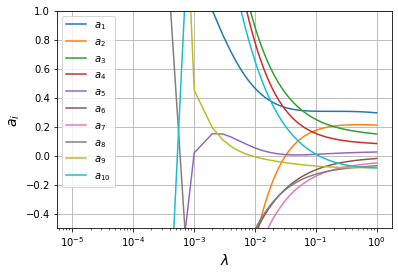

In [12]:
# Plot weight.
for i in range(0,model_order): 
    plt.plot(lambdas, a_hist[i,:], label='$a_{'+str(i+1)+'}$')
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=14)
plt.ylabel('$a_i$', fontsize=14)
plt.legend(loc='upper left')
plt.ylim([-0.5, 1])
plt.grid()
#Show the plot.
plt.show()